In [1]:
# Exploring the adult data set from the UCI repository.
# Download the files adult.data and adult.test
# from https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

from __future__ import print_function

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import numpy as np
import adult
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from forest_clusters import ForestClusters, buckets, total_variation
from display_cluster import display_cluster, CompressedForest
from category_encoders.one_hot import OneHotEncoder as CEOneHotEncoder

In [2]:
# First, let's import the adult data set and clean it up

original = adult.original
categorical = [col for col in original.columns 
               if not np.issubdtype(original[col].dtype, np.number)]
original[categorical] = original[categorical].fillna(value = 'None')
# Make sex a boolean feature
original = original.assign(male = original['sex'] == 'Male')
original = original[original.columns.difference(['sex'])]
                                                 
sanitized = original[original.columns.difference(['target'])]
# sanitized = sanitized.assign(Workclass = sanitized['Workclass'].replace(['Without-pay'], value='None'))
# sanitized = sanitized.assign(Relationship = sanitized['Relationship'].replace(['Husband', 'Wife'], value = 'Spouse'))
# sanitized = sanitized[sanitized.columns.difference(['Capital Gain', 'Capital Loss', 'Education-Num'])] # Removing important features
# sanitized = sanitized[sanitized.columns.difference(['Marital Status', 'Relationship'])] # Removing important features
# sanitized = sanitized[sanitized.columns.difference(['Occupation', 'Workclass', 'Hours per week'])] # Removing important features
# sanitized = sanitized[sanitized.columns.difference(['Race', 'Male', 'Age'])] # Removing important features
# sanitized = sanitized[sanitized.columns.difference(['Country'])] # Removing important features
enc = CEOneHotEncoder(use_cat_names = True, handle_unknown =  'ignore').fit(sanitized)
                                                 
X = enc.transform(sanitized)
y = adult.labels

In [3]:
# Train a boosting model for binary classification.
# The model is a set of decision trees. Given a point, each tree
# outputs a score that counts towards the point's probability of
# belonging in the positive class.

original_train, original_test, X_train, X_test, y_train, y_test = train_test_split(original, X, y, test_size = 0.1)

from xgboost import XGBClassifier

n_estimators = 1200

boost = GradientBoostingClassifier(n_estimators = n_estimators, max_depth = 2, min_samples_leaf = 100).fit(X_train, y_train)
print("Mean %f" % y.mean())
print("Train score %f" % boost.score(X_train, y_train))
print("Test score %f" % boost.score(X_test, y_test))

/home/arthur/python-envs/explanations/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Mean 0.239282
Train score 0.878336
Test score 0.872876


In [11]:
from sklearn.linear_model import LogisticRegression
X2 = X[['marital_status_Married-civ-spouse', 'age', 'capital_gain', 'capital_loss', 'education_num']]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size = 0.1)
m = LogisticRegression(C = 1.5, solver = 'lbfgs').fit(X2_train, y2_train)
print('Train', m.score(X2_train, y2_train))
print('Test', m.score(X2_test, y2_test))

Train 0.8412767022317265
Test 0.8474923234390993


In [13]:
# We work with data points in a transformed space of tree paths.
# Given a point, we compute the vector of leaf nodes that the point
# reached on each tree, under a one-hot encoding.
# Each leaf corresponds uniquely to a path traversed in the tree.

leaves = boost.apply(X).reshape(len(X), n_estimators)
leaf_encoder = OneHotEncoder(categories = 'auto').fit(leaves)
leaf_encoder.transform(leaves)

<48842x4714 sparse matrix of type '<class 'numpy.float64'>'
	with 58610400 stored elements in Compressed Sparse Row format>

In [14]:
# We can cluster these points using the scores assigned by each
# tree in the model, running PCA first to reduce the dimension.

n_clusters = 7
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD

X_enc = np.array([boost.estimators_[k, 0].predict(X) for k in range(boost.n_estimators)]).transpose()
X_pca = TruncatedSVD(n_components = 10).fit_transform(X_enc)
X_enc = X_pca # Comment this line to disable PCA
clustering = KMeans(n_clusters = n_clusters).fit(X_pca)
clusters = clustering.predict(X_pca)

<Figure size 480x480 with 0 Axes>

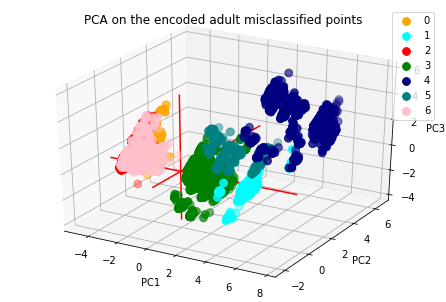

In [16]:
# Here is the result of running PCA on the encoded points

my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

from mpl_toolkits.mplot3d import axes3d, Axes3D
 
# Store results of PCA in a data frame
result=pd.DataFrame(X_pca[:,range(3)], columns=['PCA%i' % i for i in range(3)])
 
# Plot initialisation
fig = plt.figure()
ax = Axes3D(fig)

colors = ['orange', 'cyan', 'red', 'green', 'navy', 'teal', 'pink', 'yellow', 'purple', 'black']

for k, c in zip(range(n_clusters), colors):
    ax.scatter(result['PCA0'][clusters == k],
               result['PCA1'][clusters == k],
               result['PCA2'][clusters == k],
               c=c, cmap="Set2_r", s=60, label=k)

# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on the encoded adult points")
ax.legend()
#plt.show()

In [17]:
from display_cluster import display_cluster

def encode_features(original):
    return X.loc[original.index]

display_cluster(boost, original, original, y, 
                leaves.astype(int),
                clusters, n_clusters,
                encode_features=encode_features)

,Size,Accuracy,Winner,Mean Winner Prob.
0,9188,0.996517,False,0.995923
1,5218,0.729015,True,0.650724
2,12780,0.969327,False,0.965089
3,14510,0.762233,False,0.723879
4,2213,0.990059,True,0.983219
5,887,0.975197,True,0.951559
6,4046,0.842561,False,0.808876


interactive(children=(BoundedIntText(value=0, description='Cluster', max=7), Dropdown(description='Column', op…

In [18]:
from display_cluster import InfluentialPaths
paths = InfluentialPaths(boost, leaves.astype(int), X, clusters, n_clusters)

In [19]:
def refine_interval(i, direction, threshold):
    if i == ():
        return ()
    if direction == 'left':
        return (i[0], min(threshold, i[1])) if threshold > i[0] else ()
    # direction == 'right'
    return (max(threshold, i[0]), i[1]) if threshold < i[1] else ()

def summarize_cluster(k, n_paths):
    s = {}
    for rank in range(n_paths):
        forest_path = paths[k, rank]
        for node, feature, threshold, direction in forest_path.path:
            if direction != None:
                i = s[feature] if feature in s else (float('-inf'), float('inf'))
                s[feature] = refine_interval(i, direction, threshold)
    return s

def summary_mask(s, X):
    mask = pd.Series(np.ones(len(X), dtype=bool))
    for feature, i in s.items():
        if i == ():
            return pd.Series(np.zeros(len(X), dtype=bool))
        mask = mask & X[feature].between(i[0], i[1])
    return mask

k = 4
n_paths = 3

s = summarize_cluster(k, n_paths)


In [20]:
lengths = [1, 1, 1, 5, 5, 1, 1, 5, 9, 3]
ss = [summarize_cluster(i, l) for i, l in zip(range(n_clusters), lengths)]
ts = [summary_mask(s, X) for s in ss]
for k, s, t in zip(range(n_clusters), ss, ts):
    print(k)    
    m = t
    mk = clusters == k
    mmk = m & mk
    print('Summary size', sum(m))
    print('Cluster size', sum(mk))
    print('Overlap size', sum(m & mk))
    print('Cluster to summary %.3f' % (sum(m & mk) / sum(mk)))
    print('Summary to cluster %.3f' % (sum(m & mk) / sum(m)))
    display(s)

0
Summary size 26000
Cluster size 9188
Overlap size 9174
Cluster to summary 0.998
Summary to cluster 0.353


{'marital_status_Married-civ-spouse': (-inf, 0.5),
 'capital_gain': (-inf, 7055.5)}

1
Summary size 6662
Cluster size 5218
Overlap size 5170
Cluster to summary 0.991
Summary to cluster 0.776


{'marital_status_Married-civ-spouse': (0.5, inf), 'education_num': (12.5, inf)}

2
Summary size 26000
Cluster size 12780
Overlap size 12780
Cluster to summary 1.000
Summary to cluster 0.492


{'marital_status_Married-civ-spouse': (-inf, 0.5),
 'capital_gain': (-inf, 7055.5)}

3
Summary size 5485
Cluster size 14510
Overlap size 5232
Cluster to summary 0.361
Summary to cluster 0.954


{'marital_status_Married-civ-spouse': (0.5, inf),
 'capital_gain': (-inf, 5095.5),
 'education_num': (9.5, 12.5)}

4
Summary size 1776
Cluster size 2213
Overlap size 1751
Cluster to summary 0.791
Summary to cluster 0.986


{'marital_status_Married-civ-spouse': (0.5, inf),
 'capital_gain': (5119.0, inf)}

5
Summary size 1484
Cluster size 887
Overlap size 887
Cluster to summary 1.000
Summary to cluster 0.598


{'capital_gain': (-inf, 5119.0), 'capital_loss': (1820.5, inf)}

6
Summary size 26000
Cluster size 4046
Overlap size 4046
Cluster to summary 1.000
Summary to cluster 0.156


{'marital_status_Married-civ-spouse': (-inf, 0.5),
 'capital_gain': (-inf, 7055.5)}

In [21]:
X_red = pd.DataFrame({k: ts[k] for k in range(len(ts))})
(len(ts[0]), sum(ts[0] | ts[1] | ts[2] | ts[3] | ts[4])) #  | ts[5] | ts[6] | ts[7] | ts[8] | ts[9]))

(48842, 38913)

In [24]:
from sklearn.linear_model import LogisticRegression 
iterations = 20
scores = np.zeros(iterations, dtype=float)
for i in range(iterations):
    X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y, test_size = 0.1)
    forest_red = LogisticRegression(solver = 'lbfgs').fit(X_red_train, y_red_train)
    scores[i] = forest_red.score(X_red_test, y_red_test)
    
print('Test mean', scores.mean())

Test mean 0.8399795291709313


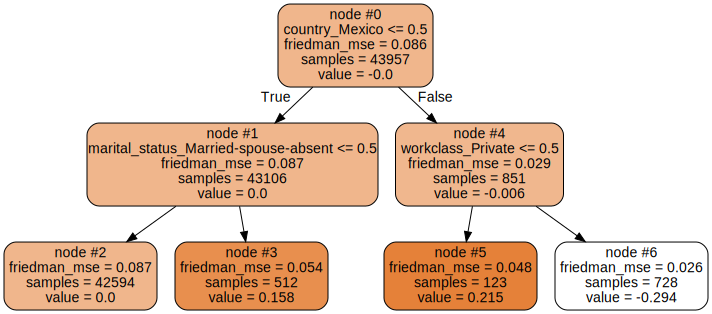

In [25]:
# The paths tends to have a lot of redundancy in terms
# of classification behavior

from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(boost.estimators_[799, 0],
                           feature_names = X_test.columns,
                           out_file = None, filled = True,
                           rounded = True, node_ids = True)
graph = graphviz.Source(dot_data)
graph

In [26]:
# Greedy path clustering

from display_cluster import InfluentialPaths

mclusters = np.zeros(len(X))
leaves = boost.apply(X).reshape((len(X), boost.n_estimators)).astype(int)
r = np.ones(len(X), dtype=bool)
n_clusters = 5

for k in range(n_clusters - 1):
    paths = InfluentialPaths(boost, leaves[r], X[r], np.zeros(sum(r)), 1)
    p = paths[0, 0]
    c = leaves[:,p.tree] == p.first_node
    t = np.logical_and(r, c)
    r = np.logical_and(r, c == False)
    mclusters = mclusters + k * t
    
mclusters = mclusters + (n_clusters - 1) * r

In [27]:
print(sum((mclusters == 2) & (clusters == 1)))
print(sum((mclusters == 0) & (clusters == 2)))
print(sum((mclusters == 1) & (clusters == 4)))
print(sum((mclusters == 3) & (clusters == 3)))
print(sum((mclusters == 0) & (clusters == 0)))

47
12780
999
14
9174


In [28]:
display_cluster(boost, original, original, y, 
                leaves, mclusters, n_clusters,
                encode_features=encode_features)

,Size,Accuracy,Winner,Mean Winner Prob.
0,26000,0.959192,False,0.951659
1,6662,0.788352,True,0.726492
2,14951,0.767574,False,0.706250
3,766,0.983029,True,0.970201
4,463,0.978402,True,0.965498


interactive(children=(BoundedIntText(value=0, description='Cluster', max=5), Dropdown(description='Column', op…

In [31]:
from display_cluster import InfluentialPaths
paths = InfluentialPaths(boost, leaves.astype(int), X, mclusters, n_clusters)

In [32]:
k = 4
n_paths = 3

s = summarize_cluster(k, n_paths)

In [33]:
lengths = [1, 1, 1, 5, 5, 1, 1, 5, 9, 3]
ss = [summarize_cluster(i, l) for i, l in zip(range(n_clusters), lengths)]
ts = [summary_mask(s, X) for s in ss]
for k, s, t in zip(range(n_clusters), ss, ts):
    print(k)    
    m = t
    mk = mclusters == k
    mmk = m & mk
    print('Summary size', sum(m))
    print('Cluster size', sum(mk))
    print('Overlap size', sum(m & mk))
    print('Cluster to summary %.3f' % (sum(m & mk) / sum(mk)))
    print('Summary to cluster %.3f' % (sum(m & mk) / sum(m)))
    display(s)

0
Summary size 26000
Cluster size 26000
Overlap size 26000
Cluster to summary 1.000
Summary to cluster 1.000


{'marital_status_Married-civ-spouse': (-inf, 0.5),
 'capital_gain': (-inf, 7055.5)}

1
Summary size 6662
Cluster size 6662
Overlap size 6662
Cluster to summary 1.000
Summary to cluster 1.000


{'marital_status_Married-civ-spouse': (0.5, inf), 'education_num': (12.5, inf)}

2
Summary size 20603
Cluster size 14951
Overlap size 14951
Cluster to summary 1.000
Summary to cluster 0.726


{'marital_status_Married-civ-spouse': (0.5, inf),
 'capital_gain': (-inf, 5095.5)}

3
Summary size 1776
Cluster size 766
Overlap size 766
Cluster to summary 1.000
Summary to cluster 0.431


{'marital_status_Married-civ-spouse': (0.5, inf),
 'capital_gain': (5119.0, inf)}

4
Summary size 433
Cluster size 463
Overlap size 433
Cluster to summary 0.935
Summary to cluster 1.000


{'marital_status_Married-civ-spouse': (-inf, 0.5),
 'capital_gain': (8296.0, inf)}

In [34]:
from sklearn.linear_model import LogisticRegression 
iterations = 20
scores = np.zeros(iterations, dtype=float)
for i in range(iterations):
    X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y, test_size = 0.1)
    forest_red = LogisticRegression(solver = 'lbfgs').fit(X_red_train, y_red_train)
    scores[i] = forest_red.score(X_red_test, y_red_test)
    
print('Test mean', scores.mean())

Test mean 0.8395598771750257
